# Digital Earth Africa: CEOS Analysis-Ready Data

## A comparison between Level 1 and Level 2 data using Modified Normalised Difference Water Index (MNDWI)

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), [ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene)
* **Level 1 data retrived from:**
[Landsat 8 Level 1 data](https://registry.opendata.aws/landsat-8/) (last accessed 10 July 2020)

In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
from datacube.utils import masking
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import xarray as xr
import numpy as np
import seaborn as sns
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb
from deafrica_plotting import display_map
from deafrica_spatialtools import subpixel_contours
from deafrica_datahandling import wofs_fuser, mostcommon_crs

/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Viewer requires Qt
  app.launch_new_instance()


In [2]:
dc = datacube.Datacube(app="L1_L2_MNDWI_Comparison_C2")

In [3]:
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type']
dc_products[dc_products['name'].str.contains("ls8|ls8")][display_columns].set_index('name')

,description,product_type
name,,
ga_ls8c_fractional_cover_2,Landsat Fractional Cover based on USGS Scenes,NaN
ga_ls8c_gm_2_annual,"Annual Geometric Median, Landsat 8",NaN
ga_ls8c_wofs_2,Historic Flood Mapping Water Observations from...,NaN
ga_ls8c_wofs_2_annual_summary,Water Observations from Space Annual Statistics,NaN
ga_ls8c_wofs_2_summary,Water Observations from Space Full History Sta...,NaN
ga_ls8c_wofs_2_terrain,"Water Observations from Space, with terrain mask",NaN
ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Higher Level SR sc...,LEVEL2_USGS
usgs_ls8c_level2_2,Sample USGS Level 2 Collection 2 Landsat,NaN


In [4]:
## Define the area of interest
lat = 12.035
lon = -15.97
buffer = 0.06

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Set the range of dates for the analysis
time = ("2018-01-01", "2018-01-24")

#display_map(x=lon_range, y=lat_range)


In [5]:
# Create query for Collection 2 surface reflectance
product = ['usgs_ls8c_level2_2']
measurements = ['green','swir1', 'red', 'blue']

query = {
    "x": lon_range,
    "y": lat_range,
    "time": time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32628"
}

# Load dataset
l2_data_full = dc.load(product=product, measurements = measurements, **query)

print(l2_data_full)

<xarray.Dataset>
Dimensions:      (time: 3, x: 438, y: 445)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T11:21:47.141989 ... 2018-01-16T11:27:54.580413
  * y            (y) float64 1.337e+06 1.337e+06 ... 1.324e+06 1.324e+06
  * x            (x) float64 3.879e+05 3.879e+05 3.879e+05 ... 4.01e+05 4.01e+05
    spatial_ref  int32 32628
Data variables:
    green        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    swir1        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    red          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    blue         (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


In [6]:
print(l2_data_full.x)

<xarray.DataArray 'x' (x: 438)>
array([387870., 387900., 387930., ..., 400920., 400950., 400980.])
Coordinates:
  * x            (x) float64 3.879e+05 3.879e+05 3.879e+05 ... 4.01e+05 4.01e+05
    spatial_ref  int32 32628
Attributes:
    units:       metre
    resolution:  30.0
    crs:         EPSG:32628


In [7]:
# Loading l1 scene from 9 Jan 2018

l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')
l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')
l1_data_full = l1_green.to_dataset(name = 'green')
l1_data_full['swir1'] = l1_swir1

In [8]:
print(l1_data_full)

# gotta change CRS
# gotta find matching x and y sets? the x and y don't match at all

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    swir1        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0


In [9]:
l2_data = l2_data_full.isel(time=1)
l1_data = l1_data_full.sel(x = slice(l2_data.x.values[0], l2_data.x.values[-1]), y = slice(l2_data.y.values[0], l2_data.y.values[-1]))

In [10]:
print(l1_data)


<xarray.Dataset>
Dimensions:      (x: 438, y: 445)
Coordinates:
  * y            (y) float64 1.337e+06 1.337e+06 ... 1.324e+06 1.324e+06
  * x            (x) float64 3.879e+05 3.879e+05 3.879e+05 ... 4.01e+05 4.01e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) uint16 8425 8323 8402 8437 8462 ... 8484 8576 8885 9423
    swir1        (y, x) uint16 11337 10349 10861 11413 ... 8022 8227 8250 7700


In [11]:
l1_data = calculate_indices(l1_data, index = 'MNDWI', collection = 'c1') 
l2_data = calculate_indices(l2_data, index = 'MNDWI', collection = 'c1')
# can use c1 reference even though l2_data is c2, because for some reason it looks for swir_1

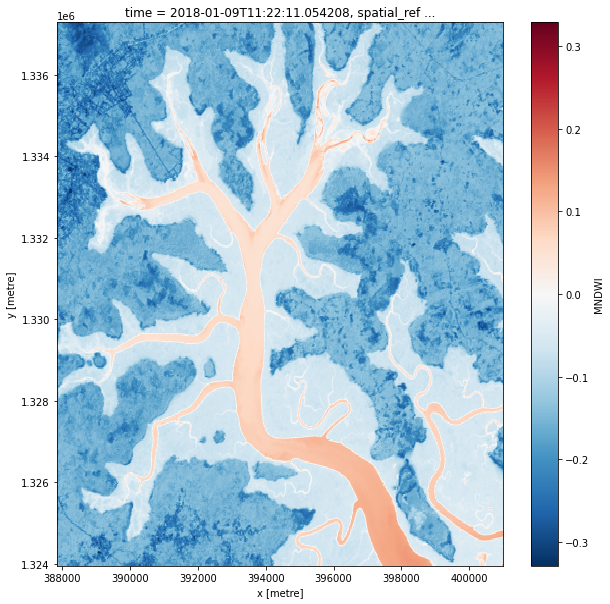

In [12]:
l2_data.MNDWI.plot(figsize = (10,10))

Text(0.5, 1.0, 'Level 2 MNDWI')

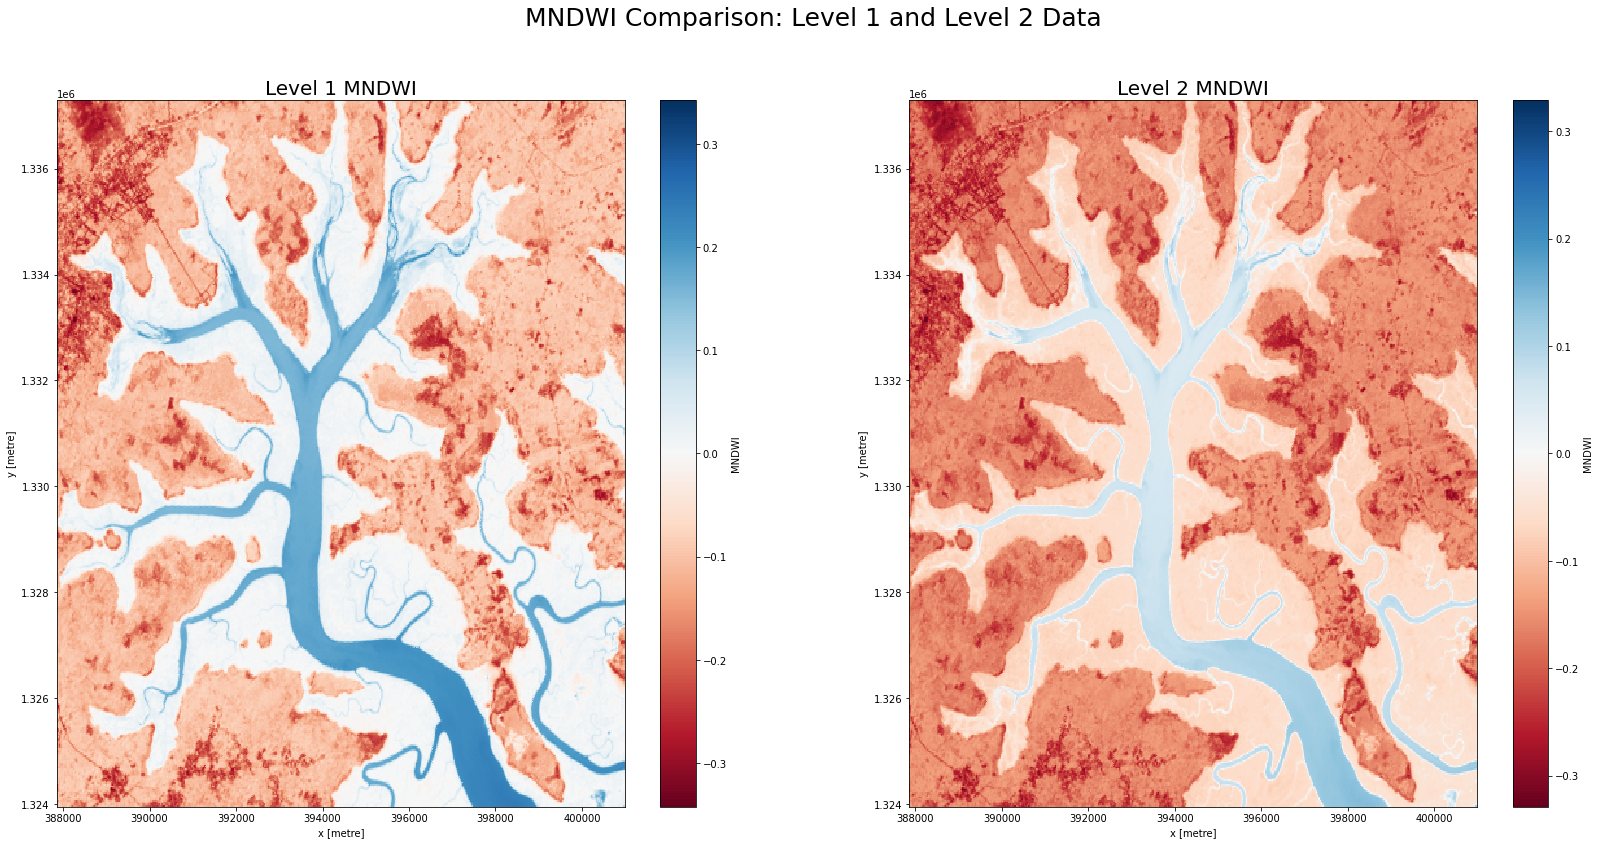

In [13]:
fig1, ax = plt.subplots(1, 2, figsize=(28,13))
fig1.suptitle("MNDWI Comparison: Level 1 and Level 2 Data", size = 25)

l1_data.MNDWI.plot(ax=ax[0], cmap='RdBu')
ax[0].set_title('Level 1 MNDWI', size = 20)

l2_data.MNDWI.plot(ax=ax[1], cmap='RdBu')
ax[1].set_title('Level 2 MNDWI', size = 20)

#vmin = -1, vmax = 1

/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


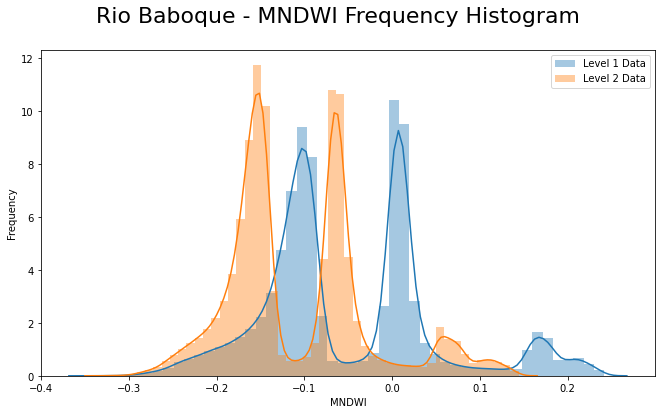

In [14]:
histl1 = l1_data.MNDWI.values.ravel()
histl2 = l2_data.MNDWI.values.ravel()

fig4, ax = plt.subplots(1, figsize=(11, 6))
fig4.suptitle("Rio Baboque - MNDWI Frequency Histogram", size = 22)

h1 = sns.distplot(histl1)
h2 = sns.distplot(histl2)

ax.set_xlabel('MNDWI')
ax.set_ylabel('Frequency')
ax.legend([h1, h2], labels = ['Level 1 Data', 'Level 2 Data'], loc = 'upper right')

In [15]:
water1 = l1_data.MNDWI > 0
water2 = l2_data.MNDWI > 0

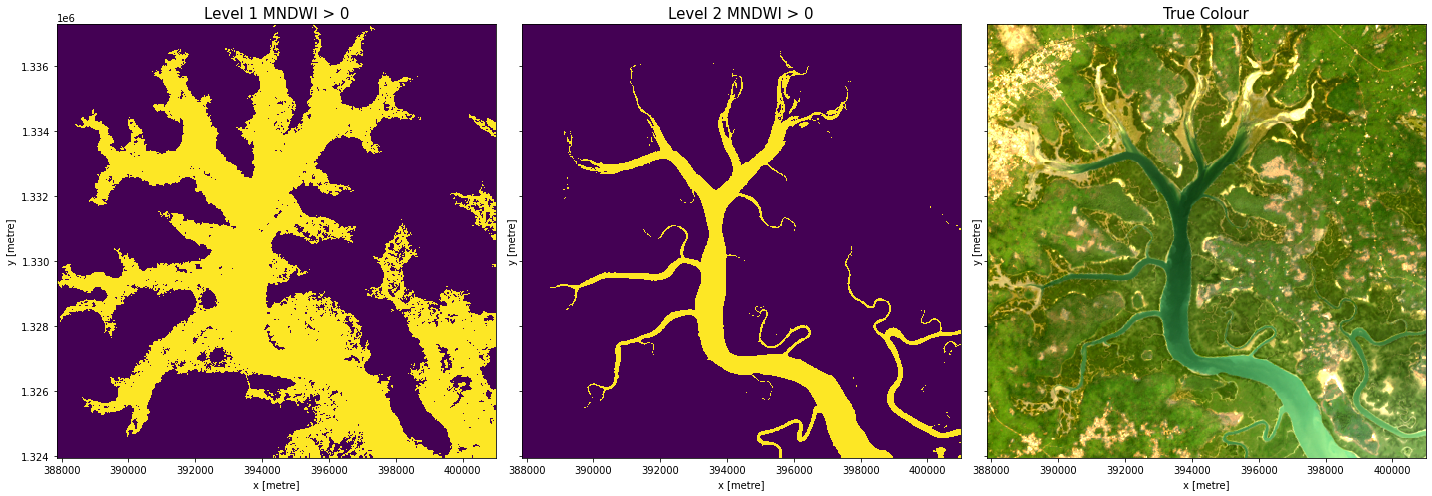

In [16]:
fig5, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 7))

water1.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('Level 1 MNDWI > 0', size = 15)

water2.plot(ax=ax[1], add_colorbar=False)
ax[1].set_title('Level 2 MNDWI > 0', size = 15)

rgb(l2_data, ax=ax[2])
ax[2].set_title('True Colour', size = 15)

plt.tight_layout()

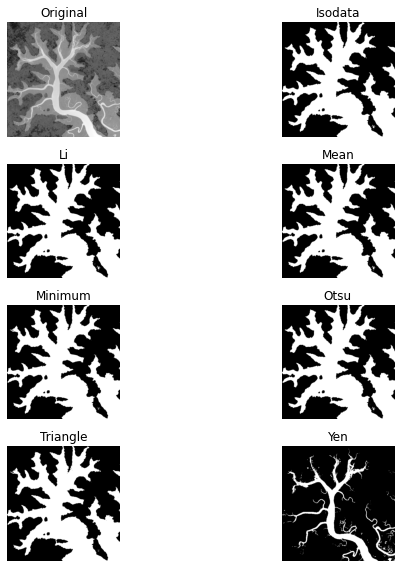

In [17]:
fig, ax = skimage.filters.try_all_threshold(l2_data.MNDWI.values, figsize=(10, 8), verbose=False)
plt.show()

In [18]:
l1_threshold = skimage.filters.threshold_yen(histl1)
print("The Rio Baboque 9 Jan 2018 Level 1 threshold is {:.4f}.".format(l1_threshold))

The Rio Baboque 9 Jan 2018 Level 1 threshold is 0.0304.


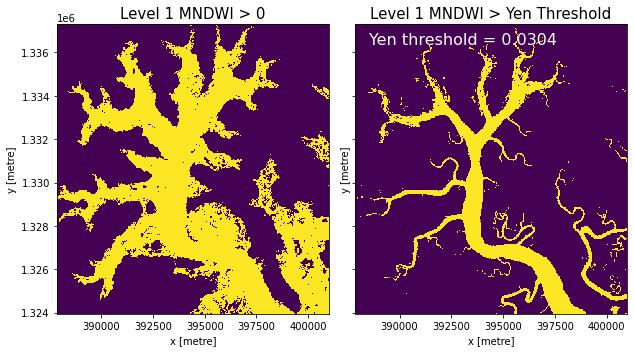

In [19]:
l1_thresholded = l1_data.MNDWI > l1_threshold

fig7, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(9, 5))
plt.locator_params(axis='x', nbins=6)

water1.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('Level 1 MNDWI > 0', size = 15)

l1_thresholded.plot(ax=ax[1], add_colorbar=False)
ax[1].set_title('Level 1 MNDWI > Yen Threshold', size = 15)
ax[1].annotate('Yen threshold = {:.4f}'.format(l1_threshold), fontsize = 16, xy = (0.05, 0.93), xycoords = 'axes fraction', color = 'white')

plt.tight_layout()

In [23]:
# Load the WOfS data from the datacube, making sure to use the correct product and scene ID
# wofs = dc.load(product = "ls_usgs_wofs_scene",
#                             fuse_func=wofs_fuser,    
#                             id = 'b7415d0e-47d5-4130-824e-856214e115f1',
#                             resolution = (-30,30),
#                             align = (15,15),
#                             output_crs = l1_data.geobox.crs).squeeze()

# Create query for Collection 2 surface reflectance
product = ['ga_ls8c_wofs_2']

query = {
    "x": lon_range,
    "y": lat_range,
    "time": time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32628"
}

# Load dataset
wofs= dc.load(product=product, fuse_func=wofs_fuser, group_by="solar_day", **query).squeeze()

print(wofs)

<xarray.Dataset>
Dimensions:      (x: 438, y: 445)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.337e+06 1.337e+06 ... 1.324e+06 1.324e+06
  * x            (x) float64 3.879e+05 3.879e+05 3.879e+05 ... 4.01e+05 4.01e+05
    spatial_ref  int32 32628
Data variables:
    water        (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 128
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


In [29]:
# Define the contours using subpixel contours

contour_xmin = 393500
contour_xmax = 397500
contour_ymin = 1333000
contour_ymax = 1337000

# Different region coordinates
# contour_xmin = 398000
# contour_xmax = 402000
# contour_ymin = 1323500
# contour_ymax = 1327500

l1_contour = l1_data.MNDWI.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin))
l2_contour = l2_data.MNDWI.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin))

# Extract contours. Here min_vertices is used to smooth the contour and remove very minor features
l1_contours_gdf = subpixel_contours(da = l1_contour, z_values = l1_threshold, crs = l2_data.crs, min_vertices = 10)
l2_contours_gdf = subpixel_contours(da = l2_contour, z_values = 0, crs = l2_data.crs, min_vertices = 10)

# Create a contour for the WOfS dataset
wofs_contour = wofs.water.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)).squeeze()
wofs_contours_gdf = subpixel_contours(da = wofs_contour, z_values = 1, crs = wofs.crs, min_vertices = 10)

Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode


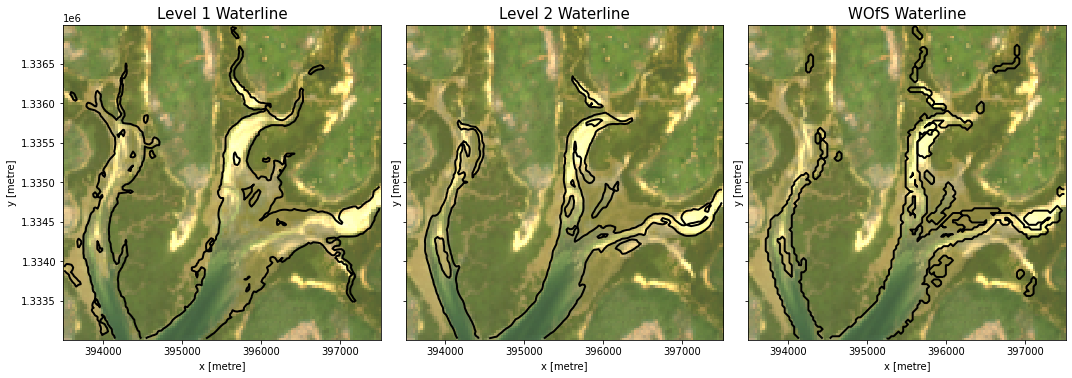

In [22]:
# Plot the data and contours

fig8, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
plt.locator_params(axis='x', nbins=5)

#l1_contour.plot(ax = ax[0], cmap = 'RdBu', vmin=-1, vmax=1, add_colorbar = False)
rgb(l2_data.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)), ax=ax[0], alpha = 0.8)
l1_contours_gdf.plot(ax = ax[0], linewidth=2, color='black')  
ax[0].set_title('Level 1 Waterline', size = 15)

#l2_contour.plot(ax = ax[1], cmap = 'RdBu', vmin=-1, vmax=1, add_colorbar = False)
rgb(l2_data.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)), ax=ax[1], alpha = 0.8)
l2_contours_gdf.plot(ax = ax[1], linewidth=2, color='black')  
ax[1].set_title('Level 2 Waterline', size = 15)



rgb(l2_data.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)), ax=ax[2], alpha = 0.8)
wofs_contours_gdf.plot(ax = ax[2], linewidth=2, color='black')  
ax[2].set_title('WOfS Waterline', size = 15)

plt.tight_layout()

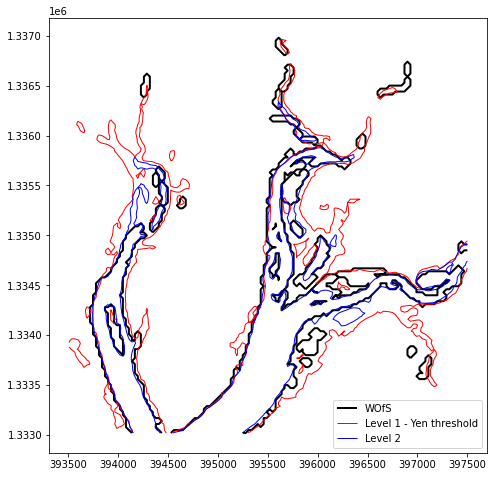

In [24]:
wofs_contours_gdf.plot(linewidth=2.0, color='black', figsize = (8, 8))  
l1_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='red')  
l2_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='blue')  

plt.legend(labels = ['WOfS', 'Level 1 - Yen threshold', 'Level 2'], loc = 'lower right')

In [31]:
#(wofs.water == 128).sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)).plot(ax = ax[2], add_colorbar = False)
#l1_contours_gdf.plot(ax = ax[2], linewidth=1.5, color='black') 
#l2_contours_gdf.plot(ax = ax[2], linewidth=3, color='green')  
#ax[2].set_title('WOfS', size = 15)

print(wofs_contour, l2_contour)



<xarray.DataArray 'water' (y: 133, x: 134)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.337e+06 1.337e+06 ... 1.333e+06 1.333e+06
  * x            (x) float64 3.935e+05 3.935e+05 ... 3.975e+05 3.975e+05
    spatial_ref  int32 32628
Attributes:
    units:             1
    nodata:            1
    flags_definition:  {'dry': {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0'...
    crs:               EPSG:32628
    grid_mapping:      spatial_ref <xarray.DataArray 'MNDWI' (y: 133, x: 134)>
array([[-0.25799714, -0.21265783, -0.19107856, ..., -0.15776732,
        -0.15006409, -0.17792654],
       [-0.23911977, -0.22723925, -0.20292208, ..., -0.14425917,
        -0.14865293, -0.16676994],
       [-0.23436733, -0.23917323, -